<a href="https://colab.research.google.com/github/ykkimhgu/DLIP-src/blob/main/Tutorial_PyTorch_MNIST_MLP_Part2_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DLIP Tutorial - PyTorch**

## MNIST Classification using PyTorch - Part 2
Y.-K. Kim
(created 2021. 5. 3) 
(updated 2024. 4. 29) 

===================

The purpose of this tutorial is to learn how to build a simple Multi-Layer Percentron (MLP or ANN) for classification of handwritting digits (MNIST)

You must do: **Tutorial_PyTorch_MNIST_MLP_Part1**  before this tutorial

* Part 1:  Build a MLP model and Train 
* Part 2:  Load Pretrained MLP model and Test 

## Setup Pytorch and Numpy and GPU

In [38]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)
import numpy as np 

2.1.2


In [39]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Prepare Datasets
### OpenDataset from TorchVision


1. Loading OpenDataset (Fashion MNIST) from Pytorch data
* ``Dataset``:  stores the samples and their corresponding labels
* ``DataLoader`` wraps an iterable around the ``Dataset``.


In [40]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [41]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),   #converts 0~255 value to 0~1 value.
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

2. Use  ``DataLoader`` to  make dataset iterable.
* supports automatic batching, sampling, shuffling and multiprocess data loading. 



In [42]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


3. Plot some training data


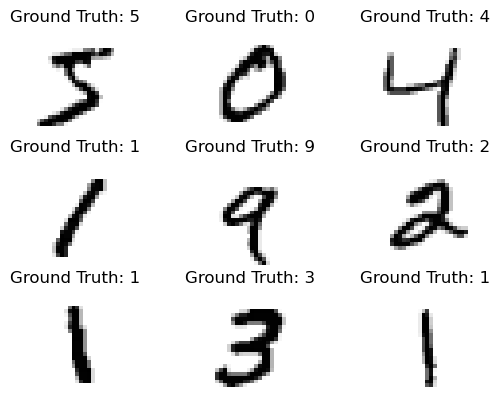

In [43]:
import matplotlib.pyplot as plt

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title("Ground Truth: {}".format(labels[index]))
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Load Pre-Trained model


1. Upload file " MNIST_model.pth "  to drive
* MNIST_model.pth from Tutorial Part 1

![image](https://user-images.githubusercontent.com/38373000/154288534-eff8ab61-fba8-47e0-9a78-c9c2f3145192.png)

### Load the pretrained model

(Option 1) Loading a model with structures 



In [44]:
model=torch.load("MNIST_model.pth")
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

(Option 2) Loading a model includes re-creating the model structure and loading the state dictionary into it.

* Need to `import` or define the Network Structure

In [50]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 250)
        self.linear2 = nn.Linear(250, 100)
        self.linear3 = nn.Linear(100, 10)

        
    def forward(self, x):
        x=self.flatten(x)
        x= F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        y_pred = F.log_softmax(self.linear3(x))
        return y_pred




In [51]:
model2 = MLP().to(device)
print(model2)
model2.load_state_dict(torch.load('MNIST_model2.pth'))
model2.eval()


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

# Test the model 

### Define **test()** function 
Using ``eval()`` for test. Evaluate mode로 전환.

This function can be reused in other tutorials

In [52]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Loss function

1. Linear regression->Mean Squared Error
2. Classification->Cross entropy,

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Test 
Print test data accuracy 

In [54]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


C:\Users\ckdal\AppData\Local\Temp\ipykernel_42572\3980131134.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.log_softmax(self.linear3(x))


Test Error: 
 Accuracy: 37.3%, Avg loss: 2.220719 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 37.3%, Avg loss: 2.220719 

Done!


### Visualize test results

Select random test images and evaluate

In [55]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
print(images.size())


# Evaluate mode로 전환
# Prediction of some sample images 
with torch.no_grad():
  for X, y in dataiter:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      _, predicted = torch.max(pred.data, 1)


torch.Size([64, 1, 28, 28])


C:\Users\ckdal\AppData\Local\Temp\ipykernel_42572\3980131134.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.log_softmax(self.linear3(x))


Plot some test image results

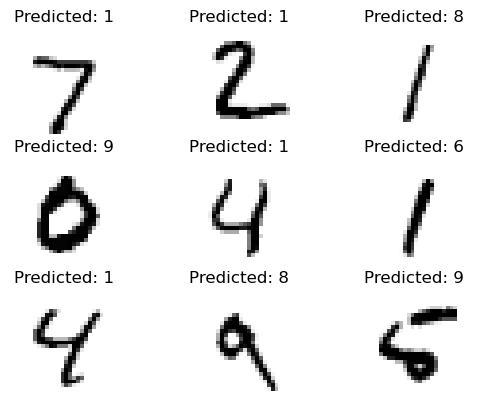

In [56]:
figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title("Predicted: {}".format(predicted[index].item()))
    plt.imshow(images[index].cpu().numpy().squeeze(), cmap='gray_r')

# Exercise


## Exercise 1
Rewrite  the above MLP model as the following. 

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)



## Exercise 2
Plot Confusion Matrix for Test Dataset

See for  `from sklearn import metrics` and ` metrics.confusion_matrix`